In [1]:
import pandas as pd
import numpy as np
import pickle
import json
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [71]:
# ============================================================================
# STEP 1: LOAD & PREPARE DATA
# ============================================================================

# Load data
episodes_df = pd.read_pickle('data/processed_episodes.pkl')
print(f" Loaded {len(episodes_df)} episodes")
print(f" Unique shows: {episodes_df['show_name'].nunique()}")
print(f" Unique categories: {episodes_df['category_simplified'].nunique()}")

# Keep only essential columns
essential_cols = [
    'transcript_clean',  # For TF-IDF
    'epTitle',
    'show_name',
    'category_simplified',
    'word_count',
    'episode_id'  # or index
]


# Create combined text for BERT (title + transcript)
episodes_df['text_bert'] = (
    episodes_df['epTitle'].fillna('') + '. ' + 
    episodes_df['transcript_clean'].fillna('')
)

# Text for TF-IDF (transcript only, stopwords will be removed by vectorizer)
episodes_df['text_tfidf'] = episodes_df['transcript_clean'].fillna('')

print(f"✓ Feature engineering complete")
print(f"  Columns retained: {len(essential_cols) + 2}")

 Loaded 9913 episodes
 Unique shows: 1813
 Unique categories: 18
✓ Feature engineering complete
  Columns retained: 8


In [5]:
# ============================================================================
# STEP 2: SHOW-LEVEL TRAIN/TEST SPLIT (NO LEAKAGE!)
# ============================================================================


# Get unique shows
unique_shows = episodes_df['show_name'].unique()

# 80/20 split on shows
np.random.seed(42)
train_shows, test_shows = train_test_split(
    unique_shows, test_size=0.2, random_state=42
)

print(f" Train shows: {len(train_shows)}")
print(f" Test shows: {len(test_shows)}")

# Split episodes
train_df = episodes_df[episodes_df['show_name'].isin(train_shows)].copy()
test_df = episodes_df[episodes_df['show_name'].isin(test_shows)].copy()

print(f"\n Episode split:")
print(f" Train episodes: {len(train_df)} ({len(train_df)/len(episodes_df)*100:.1f}%)")
print(f" Test episodes: {len(test_df)} ({len(test_df)/len(episodes_df)*100:.1f}%)")

# Verify no show overlap
assert len(set(train_df['show_name']) & set(test_df['show_name'])) == 0, "Show leakage detected!"
print(f" No show overlap verified")

# Reset indices for clean access
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

 Train shows: 1450
 Test shows: 363

 Episode split:
 Train episodes: 8059 (81.3%)
 Test episodes: 1854 (18.7%)
 No show overlap verified


In [ ]:
import joblib
from scipy import sparse
tfidf_vectorizer = joblib.load('output_files/tfidf_vectorizer.joblib')
tfidf_train = sparse.load_npz('output_files/tfidf_train.npz')
tfidf_test = sparse.load_npz('output_files/tfidf_test.npz')

In [72]:
# ============================================================================
# STEP 3: TF-IDF PIPELINE
# ============================================================================

print("\n Fitting TF-IDF on training data")
tfidf_vectorizer = TfidfVectorizer(
    max_features=10000,
    stop_words='english',
    ngram_range=(1, 2),
    min_df=3,
    max_df=0.7,
    sublinear_tf=True,
    strip_accents='unicode'
)

# Fit on train, transform both
tfidf_train = tfidf_vectorizer.fit_transform(train_df['text_tfidf'])
tfidf_test = tfidf_vectorizer.transform(test_df['text_tfidf'])

print(f"\n✓ TF-IDF matrices created:")
print(f"  Train shape: {tfidf_train.shape}")
print(f"  Test shape: {tfidf_test.shape}")
print(f"  Vocabulary size: {len(tfidf_vectorizer.vocabulary_)}")
print(f"  Sparsity: {(1 - tfidf_train.nnz / (tfidf_train.shape[0] * tfidf_train.shape[1]))*100:.2f}%")


joblib.dump(tfidf_vectorizer, 'output_files/tfidf_vectorizer.joblib')
sparse.save_npz('output_files/tfidf_train.npz', tfidf_train)
sparse.save_npz('output_files/tfidf_test.npz', tfidf_test)

print(f"\n Saved: tfidf_vectorizer.joblib, tfidf_train.npz, tfidf_test.npz")


 Fitting TF-IDF on training data

✓ TF-IDF matrices created:
  Train shape: (8059, 10000)
  Test shape: (1854, 10000)
  Vocabulary size: 10000
  Sparsity: 91.64%

 Saved: tfidf_vectorizer.joblib, tfidf_train.npz, tfidf_test.npz


In [ ]:
# ============================================================================
# STEP 4: BERT EMBEDDINGS
# ============================================================================
from sentence_transformers import SentenceTransformer
import torch

# Check if embeddings already exist
try:
    bert_train = np.load('output_files/bert_train.npy')
    bert_test = np.load('output_files/bert_test.npy')
    print(f" Loaded existing embeddings:")
    print(f" Train: {bert_train.shape}")
    print(f" Test: {bert_test.shape}")
except FileNotFoundError:
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"\n Loading BERT model (device: {device})...")
    model = SentenceTransformer('all-MiniLM-L6-v2', device=device)
    
    # Prepare texts (truncate to avoid token limits)
    train_texts = [text[:4000] for text in train_df['text_bert']]
    test_texts = [text[:4000] for text in test_df['text_bert']]
    
    # Encode train
    bert_train = model.encode(
        train_texts,
        batch_size=32,
        show_progress_bar=True,
        convert_to_numpy=True,
        normalize_embeddings=True  # L2 normalization
    )
    
    # Encode test
    bert_test = model.encode(
        test_texts,
        batch_size=32,
        show_progress_bar=True,
        convert_to_numpy=True,
        normalize_embeddings=True
    )
    
    # Save
    np.save('output_files/bert_train.npy', bert_train)
    np.save('output_files/bert_test.npy', bert_test)
    
    print(f"\n BERT embeddings generated and saved")
    print(f"  Train shape: {bert_train.shape}")
    print(f"  Test shape: {bert_test.shape}")

In [8]:
# ============================================================================
# STEP 5: REWORK EVALUATION FRAMEWORK
# ============================================================================

def create_semantic_relevance_labels(query_df, candidate_df, bert_query, bert_candidates, 
                                      mode='exploration'):
    """
    Create relevance labels based on SEMANTIC similarity + metadata
    
    Key change: Use BERT similarity as primary signal
    
    Args:
        query_df: Query episode dataframe
        candidate_df: Candidate episodes dataframe
        bert_query: Query BERT embedding
        bert_candidates: Candidate BERT embeddings
        mode: 'exploration' or 'deep-dive'
    
    Returns:
        Dict mapping candidate_idx -> relevance_gain
    """
    relevance = {}
    
    # Calculate BERT similarities
    bert_sims = cosine_similarity(bert_query.reshape(1, -1), bert_candidates)[0]
    
    for idx, cand_row in candidate_df.iterrows():
        gain = 0
        bert_sim = bert_sims[idx]
        
        if mode == 'exploration':
            # EXPLORATION: Prioritize semantic similarity + cross-show discovery
            
            # High BERT similarity (semantic relevance)
            if bert_sim >= 0.65:
                gain = 3
            elif bert_sim >= 0.55:
                gain = 2
            elif bert_sim >= 0.45:
                gain = 1
            
            # Boost for same category (but only if already semantically similar)
            if (cand_row['category_simplified'] == query_df['category_simplified'] and 
                bert_sim >= 0.5):
                gain = min(gain + 1, 3)
            
            # Penalize same show (we want discovery)
            if cand_row['show_name'] == query_df['show_name']:
                gain = max(gain - 1, 0)
        
        else:  # deep-dive
            # DEEP-DIVE: Prioritize same show + semantic similarity
            
            if cand_row['show_name'] == query_df['show_name']:
                # Same show: use semantic similarity
                if bert_sim >= 0.55:
                    gain = 3
                elif bert_sim >= 0.45:
                    gain = 2
                else:
                    gain = 1
            else:
                # Different show: require higher semantic similarity
                if bert_sim >= 0.70:
                    gain = 2
                elif bert_sim >= 0.60:
                    gain = 1
        
        if gain > 0:
            relevance[idx] = gain
    
    return relevance

def calculate_ndcg_test(recommendations, relevant_dict, k):
    
    dcg = 0.0
    for i, (idx, _) in enumerate(recommendations[:k]):
        gain = relevant_dict.get(idx, 0)
        dcg += gain / np.log2(i + 2)
    
    ideal_gains = sorted(relevant_dict.values(), reverse=True)[:k]
    idcg = sum(gain / np.log2(i + 2) for i, gain in enumerate(ideal_gains))
    
    return dcg / idcg if idcg > 0 else 0.0

def calculate_precision_at_k(recommendations, relevant_dict, k):
   
    top_k = [idx for idx, _ in recommendations[:k]]
    relevant_in_top_k = sum(1 for idx in top_k if idx in relevant_dict and relevant_dict[idx] > 0)
    return relevant_in_top_k / k if k > 0 else 0.0

def calculate_mrr(recommendations, relevant_dict):
    
    for i, (idx, _) in enumerate(recommendations, 1):
        if idx in relevant_dict and relevant_dict[idx] > 0:
            return 1.0 / i
    return 0.0


In [9]:
# ============================================================================
# STEP 6: BASELINE RETRIEVERS (TF-IDF & BERT)
# ============================================================================


def get_tfidf_recommendations_test(query_idx, top_k=10):
    """
    TF-IDF recommendations (test query → test candidates only)
    """
    query_vector = tfidf_test[query_idx]
    similarities = cosine_similarity(query_vector, tfidf_test)[0]
    similarities[query_idx] = -1  # Exclude self
    
    top_indices = similarities.argsort()[-top_k:][::-1]
    return [(idx, similarities[idx]) for idx in top_indices]

def get_bert_recommendations_test(query_idx, top_k=10):
    """
    BERT recommendations (test query → test candidates only)
    """
    query_vector = bert_test[query_idx].reshape(1, -1)
    similarities = cosine_similarity(query_vector, bert_test)[0]
    similarities[query_idx] = -1  # Exclude self
    
    top_indices = similarities.argsort()[-top_k:][::-1]
    return [(idx, similarities[idx]) for idx in top_indices]


In [10]:
# ============================================================================
# STEP 7: HYBRID (SEMANTIC ONLY - NO METADATA!)
# ============================================================================

def get_hybrid_recommendations_test(query_idx, top_k=10, 
                                    tfidf_weight=0.4, bert_weight=0.6):
    """
    Hybrid: Weighted combination of TF-IDF + BERT (NO metadata!)
    
    For exploration mode: pure semantic
    For deep-dive mode: metadata used only at RE-RANK stage (not here)
    """
    # TF-IDF similarity
    tfidf_sims = cosine_similarity(tfidf_test[query_idx], tfidf_test)[0]
    tfidf_sims[query_idx] = -1
    
    # BERT similarity
    bert_sims = cosine_similarity(bert_test[query_idx].reshape(1, -1), bert_test)[0]
    bert_sims[query_idx] = -1
    
    # Combine (semantic only!)
    hybrid_scores = tfidf_weight * tfidf_sims + bert_weight * bert_sims
    
    top_indices = hybrid_scores.argsort()[-top_k:][::-1]
    return [(idx, hybrid_scores[idx]) for idx in top_indices]


In [ ]:
# ============================================================================
# STEP 8: GRID SEARCH FOR OPTIMAL HYBRID WEIGHTS
# ============================================================================

print("\n" + "="*70)
print("STEP 8: HYPERPARAMETER TUNING - HYBRID WEIGHTS")
print("="*70)

def tune_hybrid_weights(test_df, bert_test, n_samples=100):
    """
    Grid search for optimal TF-IDF vs BERT weighting
    """
    print("\n🔍 Grid searching hybrid weights...")
    
    weight_grid = [
        (0.2, 0.8),  # BERT-heavy
        (0.3, 0.7),
        (0.4, 0.6),  # Default
        (0.5, 0.5),  # Equal
        (0.6, 0.4),
        (0.7, 0.3),  # TF-IDF-heavy
    ]
    
    # Sample test queries
    np.random.seed(42)
    test_sample_idx = np.random.choice(len(test_df), size=min(n_samples, len(test_df)), replace=False)
    
    results = []
    
    for tfidf_w, bert_w in weight_grid:
        ndcg_scores = []
        
        for query_idx in test_sample_idx:
            # Get hybrid recommendations with these weights
            tfidf_sims = cosine_similarity(tfidf_test[query_idx], tfidf_test)[0]
            bert_sims = cosine_similarity(bert_test[query_idx].reshape(1, -1), bert_test)[0]
            
            tfidf_sims[query_idx] = -1
            bert_sims[query_idx] = -1
            
            hybrid_scores = tfidf_w * tfidf_sims + bert_w * bert_sims
            top_indices = hybrid_scores.argsort()[-10:][::-1]
            recs = [(idx, hybrid_scores[idx]) for idx in top_indices]
            
            # Calculate relevance
            query_row = test_df.iloc[query_idx]
            query_emb = bert_test[query_idx]
            
            relevance = create_semantic_relevance_labels(
                query_row, test_df, query_emb, bert_test, mode='exploration'
            )
            
            if relevance:
                ndcg = calculate_ndcg_test(recs, relevance, k=5)
                ndcg_scores.append(ndcg)
        
        avg_ndcg = np.mean(ndcg_scores) if ndcg_scores else 0.0
        results.append({
            'tfidf_weight': tfidf_w,
            'bert_weight': bert_w,
            'avg_ndcg@5': avg_ndcg
        })
        
        print(f"  TF-IDF={tfidf_w}, BERT={bert_w} → nDCG@5: {avg_ndcg:.4f}")
    
    # Find best
    best = max(results, key=lambda x: x['avg_ndcg@5'])
    print(f"\n✓ Best weights: TF-IDF={best['tfidf_weight']}, BERT={best['bert_weight']}")
    print(f"  nDCG@5: {best['avg_ndcg@5']:.4f}")
    
    return best

# Run tuning
best_weights = tune_hybrid_weights(test_df, bert_test, n_samples=100)

# Save best weights
with open('output_files/best_hybrid_weights.json', 'w') as f:
    json.dump(best_weights, f, indent=2)

print(f"\n✓ Saved: best_hybrid_weights.json")



STEP 8: HYPERPARAMETER TUNING - HYBRID WEIGHTS

🔍 Grid searching hybrid weights...
  TF-IDF=0.2, BERT=0.8 → nDCG@5: 0.7858
  TF-IDF=0.3, BERT=0.7 → nDCG@5: 0.7618
  TF-IDF=0.4, BERT=0.6 → nDCG@5: 0.7215
  TF-IDF=0.5, BERT=0.5 → nDCG@5: 0.6870
  TF-IDF=0.6, BERT=0.4 → nDCG@5: 0.6358
  TF-IDF=0.7, BERT=0.3 → nDCG@5: 0.5820

✓ Best weights: TF-IDF=0.2, BERT=0.8
  nDCG@5: 0.7858

✓ Saved: best_hybrid_weights.json


In [76]:
file_path = 'output_files/best_hybrid_weights.json' 
try:
    with open(file_path, 'r') as f:
        # Load the dictionary from the JSON file into the 'best_weights' variable
        best_weights = json.load(f)
    print(f"Loaded weights: {best_weights}")
except FileNotFoundError:
    print(f" Error: The file {file_path} was not found. Check the path.")
except Exception as e:
    print(f" An error occurred during file loading: {e}")

Loaded weights: {'tfidf_weight': 0.2, 'bert_weight': 0.8, 'avg_ndcg@5': 0.7858346206553111}


In [13]:
# ============================================================================
# STEP 9: EVALUATE ALL BASELINE MODELS
# ============================================================================


def evaluate_baseline_models(test_df, bert_test, n_samples=200):
    """
    Evaluate TF-IDF, BERT, and Hybrid on test set
    """
    print(f"\n Evaluating on {n_samples} test queries...")
    
    np.random.seed(42)
    test_sample_idx = np.random.choice(len(test_df), size=min(n_samples, len(test_df)), replace=False)
    
    models = {
        'TF-IDF': lambda idx: get_tfidf_recommendations_test(idx, top_k=10),
        'BERT': lambda idx: get_bert_recommendations_test(idx, top_k=10),
        'Hybrid': lambda idx: get_hybrid_recommendations_test(
            idx, top_k=10,
            tfidf_weight=best_weights['tfidf_weight'],
            bert_weight=best_weights['bert_weight']
        )
    }
    
    results = {name: {'ndcg@5': [], 'ndcg@10': [], 'precision@5': [], 'mrr': []} 
               for name in models.keys()}
    
    for i, query_idx in enumerate(test_sample_idx):
        if i % 50 == 0:
            print(f"  Progress: {i}/{len(test_sample_idx)}")
        
        # Get query info
        query_row = test_df.iloc[query_idx]
        query_emb = bert_test[query_idx]
        
        # Create relevance labels (exploration mode)
        relevance = create_semantic_relevance_labels(
            query_row, test_df, query_emb, bert_test, mode='exploration'
        )
        
        if not relevance:
            continue
        
        # Evaluate each model
        for model_name, get_recs_func in models.items():
            recs = get_recs_func(query_idx)
            
            ndcg5 = calculate_ndcg_test(recs, relevance, k=5)
            ndcg10 = calculate_ndcg_test(recs, relevance, k=10)
            prec5 = calculate_precision_at_k(recs, relevance, k=5)
            mrr = calculate_mrr(recs, relevance)
            
            results[model_name]['ndcg@5'].append(ndcg5)
            results[model_name]['ndcg@10'].append(ndcg10)
            results[model_name]['precision@5'].append(prec5)
            results[model_name]['mrr'].append(mrr)
    
    # Calculate averages
    print("="*70)
    print("BASELINE RESULTS")
    print("="*70)
    print(f"{'Model':<15s} {'nDCG@5':<12s} {'nDCG@10':<12s} {'Precision@5':<12s} {'MRR':<12s}")
    print("-"*70)
    
    summary = {}
    for model_name in models.keys():
        avg_ndcg5 = np.mean(results[model_name]['ndcg@5'])
        avg_ndcg10 = np.mean(results[model_name]['ndcg@10'])
        avg_prec5 = np.mean(results[model_name]['precision@5'])
        avg_mrr = np.mean(results[model_name]['mrr'])
        
        print(f"{model_name:<15s} {avg_ndcg5:<12.4f} {avg_ndcg10:<12.4f} {avg_prec5:<12.4f} {avg_mrr:<12.4f}")
        
        summary[model_name] = {
            'ndcg@5': avg_ndcg5,
            'ndcg@10': avg_ndcg10,
            'precision@5': avg_prec5,
            'mrr': avg_mrr
        }
    
    return summary

# Run evaluation
baseline_results = evaluate_baseline_models(test_df, bert_test, n_samples=200)


 Evaluating on 200 test queries...
  Progress: 0/200
  Progress: 50/200
  Progress: 100/200
  Progress: 150/200
BASELINE RESULTS
Model           nDCG@5       nDCG@10      Precision@5  MRR         
----------------------------------------------------------------------
TF-IDF          0.3919       0.3660       0.4570       0.6244      
BERT            0.8211       0.8305       0.9090       0.9750      
Hybrid          0.7978       0.8042       0.8840       0.9642      


In [77]:
with open('output_files/unsupervised_results.json', 'w') as f:
    json.dump(baseline_results, f, indent=2)

print(f"\n✓ Saved: unsupervised_results.json")


✓ Saved: unsupervised_results.json


In [14]:
from IPython.display import display, HTML
# ============================================================================
# HELPER FUNCTIONS
# ============================================================================

def search_test_episodes(query_text, top_k=10):
    """
    Search test episodes by title or show name
    
    Args:
        query_text: Search query
        top_k: Number of results
    
    Returns:
        DataFrame of matching episodes with their test indices
    """
    query_lower = query_text.lower()
    
    matches = test_df[
        test_df['epTitle'].str.lower().str.contains(query_lower, na=False, regex=False) |
        test_df['show_name'].str.lower().str.contains(query_lower, na=False, regex=False)
    ].head(top_k)
    
    return matches

In [15]:
def display_episode_card(episode_row, test_idx=None, similarity=None, rank=None, 
                         query_ep=None, show_bert_sim=True):
    """
    Display a beautiful episode card with metadata
    """
    # Build similarity badge
    sim_html = ""
    if similarity is not None:
        sim_pct = int(similarity * 100)
        if sim_pct >= 75:
            color = '#28a745'
        elif sim_pct >= 50:
            color = '#ffc107'
        else:
            color = '#dc3545'
        
        sim_html = f"""
            <div style="text-align: center; margin-left: 15px;">
                <div style="font-size: 1.8em; font-weight: bold; color: {color};">{sim_pct}%</div>
                <div style="font-size: 0.75em; color: #666;">Match</div>
            </div>
        """
    
    # Build flags
    flags = []
    if query_ep is not None:
        if episode_row['show_name'] == query_ep['show_name']:
            flags.append('<span style="background: #ffc107; color: black; padding: 3px 8px; border-radius: 3px; font-size: 0.8em;">⚠️ SAME SHOW</span>')
        if episode_row['category_simplified'] == query_ep['category_simplified']:
            flags.append('<span style="background: #17a2b8; color: white; padding: 3px 8px; border-radius: 3px; font-size: 0.8em;">✓ Same Category</span>')
        
        # Show BERT similarity if requested
        if show_bert_sim and test_idx is not None:
            query_idx = query_ep.name
            bert_sim = cosine_similarity(
                bert_test[query_idx].reshape(1, -1),
                bert_test[test_idx].reshape(1, -1)
            )[0][0]
            flags.append(f'<span style="background: #6c757d; color: white; padding: 3px 8px; border-radius: 3px; font-size: 0.8em;">BERT: {bert_sim:.3f}</span>')
    
    flags_html = " ".join(flags) if flags else ""
    
    rank_str = f"<span style='color: #2E86AB; font-weight: bold;'>#{rank}</span> " if rank else ""
    idx_str = f" <span style='color: #999; font-size: 0.9em;'>[Test IDX: {test_idx}]</span>" if test_idx is not None else ""
    
    html = f"""
    <div style="border: 2px solid #2E86AB; border-radius: 10px; padding: 15px; margin: 12px 0; background: #f8f9fa;">
        <div style="display: flex; justify-content: space-between; align-items: start;">
            <div style="flex: 1;">
                <div style="font-size: 1.1em; font-weight: bold; color: #2E86AB; margin-bottom: 8px;">
                    {rank_str}{episode_row['epTitle'][:90]}{idx_str}
                </div>
                <div style="color: #555; font-size: 0.9em; margin-bottom: 5px;">
                    <strong>🎙️ Show:</strong> {episode_row['show_name'][:60]}<br>
                    <strong>📂 Category:</strong> {episode_row['category_simplified']}<br>
                    <strong>📝 Length:</strong> {episode_row['word_count']} words (~{episode_row['word_count']//150} min)
                </div>
                {f'<div style="margin-top: 8px;">{flags_html}</div>' if flags_html else ''}
                <div style="margin-top: 10px; color: #666; font-size: 0.85em; line-height: 1.4;">
                    {episode_row['transcript_clean'][:250]}...
                </div>
            </div>
            {sim_html}
        </div>
    </div>
    """
    
    return HTML(html)

In [16]:
def get_all_recommendations(query_idx, top_k=5, show_details=True):
    """
    Get recommendations from ALL models and display them
    
    Args:
        query_idx: Test dataframe index
        top_k: Number of recommendations
        show_details: Whether to show detailed comparison
    
    Returns:
        Dict with recommendations from each model
    """
    query_ep = test_df.iloc[query_idx]
    
    # Display query
    print("\n" + "="*70)
    print(" QUERY EPISODE")
    print("="*70)
    display(display_episode_card(query_ep, test_idx=query_idx))
    
    # Get recommendations from all models
    models = {
        'TF-IDF': get_tfidf_recommendations_test(query_idx, top_k=top_k),
        'BERT': get_bert_recommendations_test(query_idx, top_k=top_k),
        'Hybrid': get_hybrid_recommendations_test(
            query_idx, top_k=top_k,
            tfidf_weight=best_weights['tfidf_weight'],
            bert_weight=best_weights['bert_weight']
        )
    }
    
    if show_details:
        # Show position-by-position comparison
        print("\n" + "="*70)
        print(" SIDE-BY-SIDE COMPARISON")
        print("="*70)
        
        for i in range(top_k):
            print(f"\n{'='*70}")
            print(f"POSITION #{i+1}")
            print(f"{'='*70}\n")
            
            for model_name, recs in models.items():
                idx, score = recs[i]
                ep = test_df.iloc[idx]
                
                # Flags
                same_show = " Same Show" if ep['show_name'] == query_ep['show_name'] else ""
                same_cat = " Same Category" if ep['category_simplified'] == query_ep['category_simplified'] else ""
                
                # BERT similarity
                bert_sim = cosine_similarity(
                    bert_test[query_idx].reshape(1, -1),
                    bert_test[idx].reshape(1, -1)
                )[0][0]
                
                flags = " | ".join(filter(None, [same_show, same_cat, f"BERT: {bert_sim:.3f}"]))
                
                print(f"  {model_name:<12s} (score: {score:.4f})")
                print(f"    {ep['epTitle'][:60]}...")
                print(f"    Show: {ep['show_name'][:50]}")
                print(f"    {flags}\n")
    
    return models


In [ ]:
def search_and_recommend(search_query, model='BERT', top_k=5):
    """
    Search for episodes and get recommendations
    
    Args:
        search_query: Search text
        model: Which model to use ('TF-IDF', 'BERT', 'Hybrid', 'Supervised')
        top_k: Number of recommendations
    """
    print("\n" + "="*70)
    print(f" SEARCHING: '{search_query}'")
    print("="*70)
    
    # Search
    results = search_test_episodes(search_query, top_k=5)
    
    if len(results) == 0:
        print("\n No episodes found. Try a different search term.")
        return None
    
    print(f"\n✓ Found {len(results)} episodes in test set:\n")
    
    # Display search results
    for idx, row in results.iterrows():
        print(f"  [{idx}] {row['epTitle'][:65]}...")
        print(f"      Show: {row['show_name']}")
        print(f"      Category: {row['category_simplified']}\n")
    
    # Get recommendations for first result
    query_idx = results.index[0]
    query_ep = test_df.iloc[query_idx]
    
    print("\n" + "="*70)
    print(f" RECOMMENDATIONS FOR: {query_ep['epTitle'][:60]}...")
    print(f"   Using model: {model}")
    print("="*70)
    
    # Get recommendations
    if model == 'TF-IDF':
        recs = get_tfidf_recommendations_test(query_idx, top_k=top_k)
    elif model == 'BERT':
        recs = get_bert_recommendations_test(query_idx, top_k=top_k)
    elif model == 'Hybrid':
        recs = get_hybrid_recommendations_test(query_idx, top_k=top_k)
    else:
        print(f" Unknown model: {model}")
        return None
    
    # Display query
    print("\n Query:")
    display(display_episode_card(query_ep, test_idx=query_idx))
    
    # Display recommendations
    print("\n Recommendations:")
    for i, (rec_idx, score) in enumerate(recs, 1):
        rec_ep = test_df.iloc[rec_idx]
        display(display_episode_card(rec_ep, test_idx=rec_idx, similarity=score, 
                                     rank=i, query_ep=query_ep, show_bert_sim=True))
    


### Search Engine Function

In [ ]:
# Example 1: Search for "technology"
search_and_recommend("technology", model='BERT', top_k=5)


 SEARCHING: 'technology'

✓ Found 1 episodes in test set:

  [1830] Preventing Staph Infections: The Latest Technology with Researche...
      Show: Finding Genius Podcast
      Category: Health & Wellness


 RECOMMENDATIONS FOR: Preventing Staph Infections: The Latest Technology with Rese...
   Using model: BERT

 Query:



 Recommendations:


### Cross-Show Discovery

In [24]:
# ============================================================================
# STEP 1: CREATE HYBRID TRAIN+TEST CANDIDATE POOL
# ============================================================================

# Combine train and test for candidate retrieval
combined_df = pd.concat([train_df.reset_index(drop=True), 
                         test_df.reset_index(drop=True)], 
                        ignore_index=True)

# Mark which dataset each episode belongs to
combined_df['split'] = ['train'] * len(train_df) + ['test'] * len(test_df)

print(f"\n Combined dataset created:")
print(f"  Total episodes: {len(combined_df)}")
print(f"  Train episodes: {len(train_df)}")
print(f"  Test episodes: {len(test_df)}")


 Combined dataset created:
  Total episodes: 9913
  Train episodes: 8059
  Test episodes: 1854


In [26]:
# ============================================================================
# STEP 2: COMBINE EMBEDDINGS
# ============================================================================

combined_tfidf = sparse.vstack([tfidf_train, tfidf_test])
combined_bert = np.vstack([bert_train, bert_test])

print(f"\n Combined embeddings:")
print(f"  TF-IDF shape: {combined_tfidf.shape}")
print(f"  BERT shape: {combined_bert.shape}")

# Create mapping from test indices to combined indices
test_to_combined_idx = {i: i + len(train_df) for i in range(len(test_df))}


 Combined embeddings:
  TF-IDF shape: (9913, 10000)
  BERT shape: (9913, 384)


In [27]:
# ============================================================================
# STEP 3: CROSS-SHOW RECOMMENDATION FUNCTIONS
# ============================================================================

def get_cross_show_recommendations_bert(test_query_idx, top_k=10, 
                                       exclude_same_show=True):
    """
    BERT recommendations from ALL episodes (train + test)
    
    Args:
        test_query_idx: Index in test_df
        top_k: Number of recommendations
        exclude_same_show: If True, filter out same-show recommendations
    
    Returns:
        List of (combined_idx, score, split) tuples
    """
    # Convert test index to combined index
    combined_query_idx = test_to_combined_idx[test_query_idx]
    
    # Calculate similarities to ALL episodes
    query_vector = combined_bert[combined_query_idx].reshape(1, -1)
    similarities = cosine_similarity(query_vector, combined_bert)[0]
    similarities[combined_query_idx] = -1  # Exclude self
    
    # Get query show for filtering
    query_show = test_df.iloc[test_query_idx]['show_name']
    
    if exclude_same_show:
        # Penalize same-show recommendations
        same_show_mask = combined_df['show_name'] == query_show
        similarities[same_show_mask] *= 0.5  # 50% penalty
    
    # Get top-k
    top_indices = similarities.argsort()[-top_k*3:][::-1]  # Get extra, filter later
    
    results = []
    for idx in top_indices:
        if len(results) >= top_k:
            break
        
        # Skip if same show and exclude flag is set
        if exclude_same_show and combined_df.iloc[idx]['show_name'] == query_show:
            continue
            
        results.append((
            idx,
            similarities[idx],
            combined_df.iloc[idx]['split']
        ))
    
    return results


def get_cross_show_recommendations_hybrid(test_query_idx, top_k=10,
                                         exclude_same_show=True,
                                         tfidf_weight=0.2, bert_weight=0.8):
    """
    Hybrid recommendations from ALL episodes (train + test)
    """
    combined_query_idx = test_to_combined_idx[test_query_idx]
    
    # TF-IDF similarities
    tfidf_sims = cosine_similarity(
        combined_tfidf[combined_query_idx], 
        combined_tfidf
    )[0]
    tfidf_sims[combined_query_idx] = -1
    
    # BERT similarities
    bert_sims = cosine_similarity(
        combined_bert[combined_query_idx].reshape(1, -1),
        combined_bert
    )[0]
    bert_sims[combined_query_idx] = -1
    
    # Combine
    hybrid_scores = tfidf_weight * tfidf_sims + bert_weight * bert_sims
    
    # Get query show
    query_show = test_df.iloc[test_query_idx]['show_name']
    
    if exclude_same_show:
        same_show_mask = combined_df['show_name'] == query_show
        hybrid_scores[same_show_mask] *= 0.5
    
    # Get top-k
    top_indices = hybrid_scores.argsort()[-top_k*3:][::-1]
    
    results = []
    for idx in top_indices:
        if len(results) >= top_k:
            break
        
        if exclude_same_show and combined_df.iloc[idx]['show_name'] == query_show:
            continue
            
        results.append((
            idx,
            hybrid_scores[idx],
            combined_df.iloc[idx]['split']
        ))
    
    return results

In [29]:
# ============================================================================
# STEP 4: COMPARISON VISUALIZATION
# ============================================================================


def compare_recommendation_modes(test_query_idx, top_k=5):
    """
    Show side-by-side comparison of same-show vs cross-show recommendations
    """
    query_ep = test_df.iloc[test_query_idx]
    desc = (
        str(query_ep.get('transcript_clean', ''))[:180]
        .replace('\n', ' ')
        .strip()
    )
    print(f"\n{'='*70}")
    print(f" QUERY EPISODE")
    print(f"{'='*70}")
    print(f"  Title: {query_ep['epTitle']}")
    print(f"  Show: {query_ep['show_name']}")
    print(f"  Category: {query_ep['category_simplified']}")
    print(f"  Description: {desc}")
    
    # Get recommendations in both modes
    same_show_recs = get_bert_recommendations_test(test_query_idx, top_k=top_k)
    cross_show_recs = get_cross_show_recommendations_bert(
        test_query_idx, top_k=top_k, exclude_same_show=True
    )
    
    print(f"\n{'='*70}")
    print(f"MODE 1: DEEP-DIVE (Same-Show Recommendations)")
    print(f"{'='*70}")
    
    for i, (idx, score) in enumerate(same_show_recs, 1):
        ep = test_df.iloc[idx]
        desc = (
            str(ep.get('transcript_clean', ''))[:180]
            .replace('\n', ' ')
            .strip()
        )
        same_show = "Same Podcast" if ep['show_name'] == query_ep['show_name'] else "Different Podcast"
        same_cat = "Same Category" if ep['category_simplified'] == query_ep['category_simplified'] else "Different Category"
        
        print(f"\n  #{i} (score: {score:.3f})")
        print(f"    {ep['epTitle']}")
        print(f"    Show: {ep['show_name']}")
        print(f"    {same_show} show | {same_cat} category")
    
    print(f"\n{'='*70}")
    print(f"MODE 2: EXPLORATION (Cross-Show Recommendations)")
    print(f"{'='*70}")
    
    for i, (combined_idx, score, split) in enumerate(cross_show_recs, 1):
        ep = combined_df.iloc[combined_idx]
        desc = (
            str(ep.get('transcript_clean', ''))[:180]
            .replace('\n', ' ')
            .strip()
        )
        same_cat = "Same" if ep['category_simplified'] == query_ep['category_simplified'] else "Different"
        
        print(f"\n  #{i} (score: {score:.3f})")
        print(f"    {ep['epTitle']}")
        print(f"    Show: {ep['show_name']}")
        print(f"    {same_cat}")
    
    # Summary statistics
    print(f"\n{'='*70}")
    print(f" COMPARISON SUMMARY")
    print(f"{'='*70}")
    
    # Same-show mode stats
    same_show_count = sum(1 for idx, _ in same_show_recs 
                          if test_df.iloc[idx]['show_name'] == query_ep['show_name'])
    
    # Cross-show mode stats  
    train_count = sum(1 for _, _, split in cross_show_recs if split == 'train')
    test_count = sum(1 for _, _, split in cross_show_recs if split == 'test')
    
    print(f"\n  Deep-Dive Mode:")
    print(f"    Same-show: {same_show_count}/{top_k}")
    print(f"    Cross-show: {top_k - same_show_count}/{top_k}")
    
    print(f"\n  Exploration Mode:")
    print(f"    From training shows: {train_count}/{top_k}")
    print(f"    From test shows: {test_count}/{top_k}")
    print(f"    All different shows: {top_k}/{top_k} ✓")

# Test with a random query
random_test_idx = np.random.randint(0, len(test_df))
compare_recommendation_modes(random_test_idx, top_k=5)


 QUERY EPISODE
  Title: Daily Coronavirus Check-in: FOGO is the new FOMO and that's ok
  Show: Healthy-ish
  Category: Health & Wellness
  Description: hello beautiful, healthiest friends. i'm nina young, the bedroom podcaster who's been receiving beautiful messages from you guys recently and i'm thrilled to know that i'm not alon

MODE 1: DEEP-DIVE (Same-Show Recommendations)

  #1 (score: 0.604)
    Daily Coronavirus Check-in: A fear of going back
    Show: Healthy-ish
    Same Podcast show | Same Category category

  #2 (score: 0.568)
    Daily Coronavirus Check-in: Why our brains are hijacking our sense of safety
    Show: Healthy-ish
    Same Podcast show | Same Category category

  #3 (score: 0.553)
    Daily Coronavirus Check-in: How to put yourself first every day
    Show: Healthy-ish
    Same Podcast show | Same Category category

  #4 (score: 0.537)
    Daily Coronavirus Check-in: How to maintain your iso-quiet in a loud world
    Show: Healthy-ish
    Same Podcast show | S


 Analyzing 50 random queries...

RESULTS SUMMARY

Mode                 Metric                         Value          
----------------------------------------------------------------------
Deep-Dive            Avg Same-Show %                32.0           
Deep-Dive            Avg BERT Similarity            0.543          

Exploration          Avg Train-Show %               80.6           
Exploration          Avg Test-Show %                19.4           
Exploration          Avg BERT Similarity            0.532          


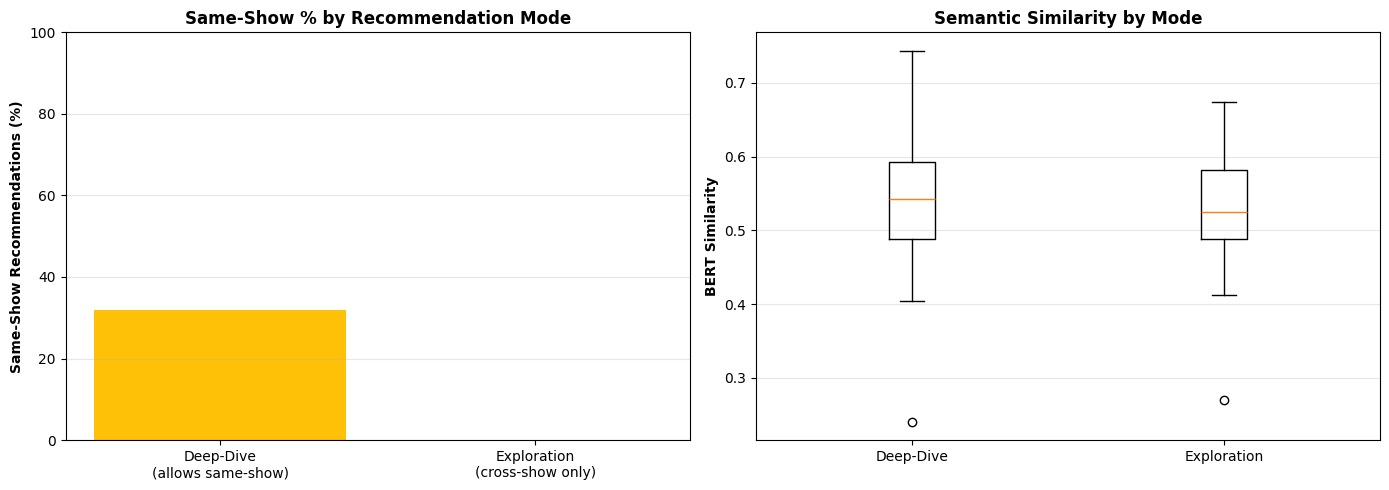


 Plot saved: recommendation_modes_comparison.png


In [31]:
# ============================================================================
# STEP 5: BATCH COMPARISON - MULTIPLE QUERIES
# ============================================================================

def batch_compare_modes(n_queries=20):
    """
    Compare same-show vs cross-show recommendations across multiple queries
    """
    print(f"\n Analyzing {n_queries} random queries...\n")
    
    np.random.seed(42)
    test_indices = np.random.choice(len(test_df), size=n_queries, replace=False)
    
    stats = {
        'deep_dive': {
            'same_show_count': [],
            'avg_bert_sim': []
        },
        'exploration': {
            'train_count': [],
            'test_count': [],
            'avg_bert_sim': []
        }
    }
    
    for test_idx in test_indices:
        query_show = test_df.iloc[test_idx]['show_name']
        combined_query_idx = test_to_combined_idx[test_idx]
        
        # Deep-dive mode
        same_show_recs = get_bert_recommendations_test(test_idx, top_k=10)
        same_show_count = sum(1 for idx, _ in same_show_recs 
                             if test_df.iloc[idx]['show_name'] == query_show)
        
        bert_sims = [cosine_similarity(
            combined_bert[combined_query_idx].reshape(1, -1),
            combined_bert[test_to_combined_idx[idx]].reshape(1, -1)
        )[0][0] for idx, _ in same_show_recs]
        
        stats['deep_dive']['same_show_count'].append(same_show_count / 10 * 100)
        stats['deep_dive']['avg_bert_sim'].append(np.mean(bert_sims))
        
        # Exploration mode
        cross_show_recs = get_cross_show_recommendations_bert(
            test_idx, top_k=10, exclude_same_show=True
        )
        
        train_count = sum(1 for _, _, split in cross_show_recs if split == 'train')
        test_count = sum(1 for _, _, split in cross_show_recs if split == 'test')
        
        bert_sims_cross = [cosine_similarity(
            combined_bert[combined_query_idx].reshape(1, -1),
            combined_bert[idx].reshape(1, -1)
        )[0][0] for idx, _, _ in cross_show_recs]
        
        stats['exploration']['train_count'].append(train_count / 10 * 100)
        stats['exploration']['test_count'].append(test_count / 10 * 100)
        stats['exploration']['avg_bert_sim'].append(np.mean(bert_sims_cross))
    
    # Print results
    print("="*70)
    print("RESULTS SUMMARY")
    print("="*70)
    
    print(f"\n{'Mode':<20s} {'Metric':<30s} {'Value':<15s}")
    print("-"*70)
    
    print(f"{'Deep-Dive':<20s} {'Avg Same-Show %':<30s} {np.mean(stats['deep_dive']['same_show_count']):<15.1f}")
    print(f"{'Deep-Dive':<20s} {'Avg BERT Similarity':<30s} {np.mean(stats['deep_dive']['avg_bert_sim']):<15.3f}")
    
    print(f"\n{'Exploration':<20s} {'Avg Train-Show %':<30s} {np.mean(stats['exploration']['train_count']):<15.1f}")
    print(f"{'Exploration':<20s} {'Avg Test-Show %':<30s} {np.mean(stats['exploration']['test_count']):<15.1f}")
    print(f"{'Exploration':<20s} {'Avg BERT Similarity':<30s} {np.mean(stats['exploration']['avg_bert_sim']):<15.3f}")
    
    # Visualization
    import matplotlib.pyplot as plt
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Plot 1: Same-show percentage comparison
    axes[0].bar(['Deep-Dive\n(allows same-show)', 'Exploration\n(cross-show only)'],
                [np.mean(stats['deep_dive']['same_show_count']), 0],
                color=['#ffc107', '#2E86AB'])
    axes[0].set_ylabel('Same-Show Recommendations (%)', fontweight='bold')
    axes[0].set_title('Same-Show % by Recommendation Mode', fontweight='bold')
    axes[0].set_ylim(0, 100)
    axes[0].grid(axis='y', alpha=0.3)
    
    # Plot 2: BERT similarity comparison
    axes[1].boxplot([stats['deep_dive']['avg_bert_sim'], 
                     stats['exploration']['avg_bert_sim']],
                    labels=['Deep-Dive', 'Exploration'])
    axes[1].set_ylabel('BERT Similarity', fontweight='bold')
    axes[1].set_title('Semantic Similarity by Mode', fontweight='bold')
    axes[1].grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('recommendation_modes_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\n Plot saved: recommendation_modes_comparison.png")

batch_compare_modes(n_queries=50)

In [38]:
# ============================================================================
# STEP 6: CATEGORY-BASED CROSS-SHOW RECOMMENDATIONS
# ============================================================================


def get_cross_show_recommendations_with_diversity(test_query_idx, top_k=10):
    """
    Cross-show recommendations with diversity control
    - Ensures mix of same-category and different-category
    - Prioritizes training set shows (true discovery)
    """
    query_ep = test_df.iloc[test_query_idx]
    combined_query_idx = test_to_combined_idx[test_query_idx]
    query_show = query_ep['show_name']
    query_cat = query_ep['category_simplified']
    
    # Get BERT similarities
    query_vector = combined_bert[combined_query_idx].reshape(1, -1)
    similarities = cosine_similarity(query_vector, combined_bert)[0]
    similarities[combined_query_idx] = -1
    
    # Separate into buckets
    same_show_mask = combined_df['show_name'] == query_show
    same_cat_mask = combined_df['category_simplified'] == query_cat
    train_mask = combined_df['split'] == 'train'
    
    # Bucket priorities:
    # 1. Different show, same category, from training
    # 2. Different show, different category, from training  
    # 3. Different show, same category, from test
    # 4. Different show, different category, from test
    
    buckets = {
        'train_same_cat': (~same_show_mask) & same_cat_mask & train_mask,
        'train_diff_cat': (~same_show_mask) & (~same_cat_mask) & train_mask,
        'test_same_cat': (~same_show_mask) & same_cat_mask & (~train_mask),
        'test_diff_cat': (~same_show_mask) & (~same_cat_mask) & (~train_mask)
    }
    
    # Select from each bucket
    results = []
    
    for bucket_name, mask in buckets.items():
        bucket_indices = np.where(mask)[0]
        if len(bucket_indices) == 0:
            continue
        
        bucket_sims = similarities[bucket_indices]
        sorted_bucket = bucket_indices[bucket_sims.argsort()[::-1]]
        
        # Take top from this bucket
        for idx in sorted_bucket[:3]:  # Max 3 per bucket
            if len(results) >= top_k:
                break
            results.append((
                idx,
                similarities[idx],
                combined_df.iloc[idx]['split'],
                bucket_name
            ))
        
        if len(results) >= top_k:
            break
    
    # Sort by score and return top-k
    results.sort(key=lambda x: x[1], reverse=True)
    return results[:top_k]


def display_diverse_recommendations(test_query_idx, top_k=8):
    """
    Display recommendations with diversity analysis
    """
    query_ep = test_df.iloc[test_query_idx]
    
    print(f"\n{'='*70}")
    print(f" QUERY EPISODE")
    print(f"{'='*70}")
    print(f"  Title: {query_ep['epTitle'][:70]}...")
    print(f"  Show: {query_ep['show_name']}")
    print(f"  Category: {query_ep['category_simplified']}")
    
    recs = get_cross_show_recommendations_with_diversity(test_query_idx, top_k=top_k)
    
    print(f"\n{'='*70}")
    print(f" DIVERSE CROSS-SHOW RECOMMENDATIONS")
    print(f"{'='*70}")
    
    for i, (combined_idx, score, split, bucket) in enumerate(recs, 1):
        ep = combined_df.iloc[combined_idx]
        
        
        same_cat = " Same Category" if ep['category_simplified'] == query_ep['category_simplified'] else " Different Category"
        
        print(f"\n  #{i} (score: {score:.3f})")
        print(f"    {ep['epTitle'][:60]}...")
        print(f"    Show: {ep['show_name'][:50]}")
        print(f"    Category: {ep['category_simplified']} ({same_cat})")
        print(f"    Bucket: {bucket}")
    
    # Stats
    train_count = sum(1 for _, _, split, _ in recs if split == 'train')
    same_cat_count = sum(1 for idx, _, _, _ in recs 
                         if combined_df.iloc[idx]['category_simplified'] == query_ep['category_simplified'])
    
    print(f"\n{'='*70}")
    print(f" DIVERSITY METRICS")
    print(f"{'='*70}")
    print(f"  Training shows: {train_count}/{top_k} ({train_count/top_k*100:.0f}%)")
    print(f"  Same category: {same_cat_count}/{top_k} ({same_cat_count/top_k*100:.0f}%)")
    print(f"  Different category: {top_k-same_cat_count}/{top_k} ({(top_k-same_cat_count)/top_k*100:.0f}%)")

# Test diverse recommendations
random_idx = np.random.randint(0, len(test_df))
display_diverse_recommendations(random_idx, top_k=8)


 QUERY EPISODE
  Title: Brother's Balm - Episode 5: Fashion in a Time of COVID-19 - 05/11/2020...
  Show: Open Lines Radio
  Category: Society & Culture

 DIVERSE CROSS-SHOW RECOMMENDATIONS

  #1 (score: 0.617)
    #37 BWO Patron Mailbag...
    Show: Busted Wide Open
    Category: Sports ( Different Category)
    Bucket: train_diff_cat

  #2 (score: 0.606)
    #32 BWO Patron Mailbag...
    Show: Busted Wide Open
    Category: Sports ( Different Category)
    Bucket: train_diff_cat

  #3 (score: 0.596)
    #38 BWO Patron Mailbag...
    Show: Busted Wide Open
    Category: Sports ( Different Category)
    Bucket: train_diff_cat

  #4 (score: 0.565)
    DnB Ep 270: Space Force Launches and Bombshell 9/11 Revelati...
    Show: Dudes n Beer Podcast
    Category: Society & Culture ( Same Category)
    Bucket: train_same_cat

  #5 (score: 0.512)
    Eps(70) when the shit hit the fan...
    Show: What’s Happening
    Category: Society & Culture ( Same Category)
    Bucket: train_same_cat

  #

In [ ]:
# ============================================================================
# STEP 7: FINAL DEMO - ALL RECOMMENDATION MODES
# ============================================================================

print("\n" + "="*70)
print("STEP 7: COMPLETE RECOMMENDATION SYSTEM DEMO")
print("="*70)

def complete_recommendation_demo(test_query_idx):
    """
    Show ALL recommendation modes for a single query
    """
    query_ep = test_df.iloc[test_query_idx]
    desc = (
        str(query_ep.get('transcript_clean', ''))[:180]
        .replace('\n', ' ')
        .strip()
    )
    print(f"\n{'='*70}")
    print(f"SELECTED EPISODE:")
    print(f"{'='*70}")
    print(f"  Title: {query_ep['epTitle']}")
    print(f"  Show: {query_ep['show_name']}")
    print(f"  Category: {query_ep['category_simplified']}")
    print(f"  Description: {desc}")
    
    
    # Mode 1: Deep-Dive (same-show allowed)
    print(f"\n{'='*70}")
    print(f"MODE 1: DEEP-DIVE Recommendations")
    print(f"Purpose: Find similar episodes within the same show")
    print(f"{'='*70}")
    
    deep_dive_recs = get_bert_recommendations_test(test_query_idx, top_k=5)
    for i, (idx, score) in enumerate(deep_dive_recs, 1):
        ep = test_df.iloc[idx]
        desc = (
        str(ep.get('transcript_clean', ''))[:180]
        .replace('\n', ' ')
        .strip()
        )
        print(f"\n  {i}. {ep['epTitle']}...")
        print(f"     Show: {ep['show_name']}")
        print(f"     Description: {desc}")
        print(f"     Category: {ep['category_simplified']}")
        print(f"     BERT Similarity: {score:.3f}")
    
    # Mode 2: Exploration (cross-show, mixed sources)
    print(f"\n{'='*70}")
    print(f"MODE 2: EXPLORATION MODE Recommendations")
    print(f"Purpose: Discover new shows with similar content")
    print(f"{'='*70}")
    
    exploration_recs = get_cross_show_recommendations_bert(
        test_query_idx, top_k=5, exclude_same_show=True
    )
    for i, (combined_idx, score, split) in enumerate(exploration_recs, 1):
        ep = combined_df.iloc[combined_idx]
        desc = (
        str(ep.get('transcript_clean', ''))[:180]
        .replace('\n', ' ')
        .strip()
        )
        
        print(f"\n  {i}. {ep['epTitle']}")
        print(f"     Show: {ep['show_name']}")
        print(f"     Description: {desc}")
        print(f"     BERT Similarity: {score:.3f}")
    
    # Mode 3: Diverse Discovery
    print(f"\n{'='*70}")
    print(f"MODE 3: DIVERSE RECOMMENDATIONS")
    print(f"Purpose: Balanced mix of similar and different categories")
    print(f"{'='*70}")
    
    diverse_recs = get_cross_show_recommendations_with_diversity(test_query_idx, top_k=5)
    for i, (combined_idx, score, split, bucket) in enumerate(diverse_recs, 1):
        ep = combined_df.iloc[combined_idx]
        desc = (
        str(ep.get('transcript_clean', ''))[:180]
        .replace('\n', ' ')
        .strip()
        )
       
        same_cat = ep['category_simplified'] == query_ep['category_simplified']
        cat_match = "Same" if same_cat else "Different"
        
        print(f"\n  {i}. {ep['epTitle']}")
        print(f"     Show: {ep['show_name']}")
        print(f"     Category: {ep['category_simplified']} {cat_match}")
        print(f"     Description: {desc}")
        print(f"     BERT Similarity: {score:.3f}")

# Run complete demo
print("\n" + "="*70)
print("RUNNING COMPLETE DEMO ON 3 RANDOM QUERIES")
print("="*70)

for i in range(3):
    random_idx = np.random.randint(0, len(test_df))
    complete_recommendation_demo(random_idx)
    if i < 2:
        print("\n\n" + "="*70)
        print("NEXT QUERY")
        print("="*70)


STEP 7: COMPLETE RECOMMENDATION SYSTEM DEMO

RUNNING COMPLETE DEMO ON 3 RANDOM QUERIES

SELECTED EPISODE:
  Title: Daily Coronavirus Check-in: FOGO is the new FOMO and that's ok
  Show: Healthy-ish
  Category: Health & Wellness
  Description: hello beautiful, healthiest friends. i'm nina young, the bedroom podcaster who's been receiving beautiful messages from you guys recently and i'm thrilled to know that i'm not alon

MODE 1: DEEP-DIVE Recommendations
Purpose: Find similar episodes within the same show

  1. Daily Coronavirus Check-in: A fear of going back...
     Show: Healthy-ish
     Description: good morning my beautiful friends, it's nina young here. i hope you guys are having an amazing week as the restrictions start to finally live. i got to visit my mum for her birthda
     Category: Health & Wellness
     BERT Similarity: 0.604

  2. Daily Coronavirus Check-in: Why our brains are hijacking our sense of safety...
     Show: Healthy-ish
     Description: good morning. hello 

In [ ]:

def complete_recommendation_demo(test_query_idx):
    """
    Show ALL recommendation modes for a single query using HTML cards
    """
    query_ep = test_df.iloc[test_query_idx]
    
   
    print(f"\n{'='*70}")
    print(f" QUERY EPISODE (Test Index: {test_query_idx})")
    print(f"{'='*70}")
    # Display the query episode card (no rank, no similarity)
    display(display_episode_card(query_ep, query_ep=query_ep, show_bert_sim=False))
    
    # Mode 1: Deep-Dive (same-show allowed)
    print(f"\n{'='*70}")
    print(f"MODE 1: DEEP-DIVE Recommendations")
    print(f"Purpose: Find similar episodes within the same show")
    print(f"{'='*70}")
    
    deep_dive_recs = get_bert_recommendations_test(test_query_idx, top_k=5)
    for i, (idx, score) in enumerate(deep_dive_recs, 1):
        ep = test_df.iloc[idx]
        # Use the HTML card function for recommendations
        display(display_episode_card(
            ep, 
            test_idx=idx, 
            similarity=score, 
            rank=i, 
            query_ep=query_ep, 
            show_bert_sim=False # Show similarity in the badge, not the flag
        ))
    
    # Mode 2: Exploration (cross-show, mixed sources)
    print(f"\n{'='*70}")
    print(f"MODE 2: EXPLORATION MODE Recommendations")
    print(f"Purpose: Discover new shows with similar content")
    print(f"{'='*70}")
    
    exploration_recs = get_cross_show_recommendations_bert(
        test_query_idx, top_k=5, exclude_same_show=True
    )
    for i, (combined_idx, score, split) in enumerate(exploration_recs, 1):
        ep = combined_df.iloc[combined_idx]
        
        # Use the HTML card function for recommendations
        display(display_episode_card(
            ep, 
            test_idx=combined_idx, 
            similarity=score, 
            rank=i, 
            query_ep=query_ep, 
            show_bert_sim=False
        ))
    
    # Mode 3: Diverse Discovery
    print(f"\n{'='*70}")
    print(f"MODE 3: DIVERSE RECOMMENDATIONS")
    print(f"Purpose: Balanced mix of similar and different categories")
    print(f"{'='*70}")
    
    diverse_recs = get_cross_show_recommendations_with_diversity(test_query_idx, top_k=5)
    for i, (combined_idx, score, split, bucket) in enumerate(diverse_recs, 1):
        ep = combined_df.iloc[combined_idx]
        
        # Use the HTML card function for recommendations
        display(display_episode_card(
            ep, 
            test_idx=combined_idx, 
            similarity=score, 
            rank=i, 
            query_ep=query_ep, 
            show_bert_sim=False
        ))

# Run complete demo
print("\n" + "="*70)
print("RUNNING COMPLETE DEMO ON 3 RANDOM QUERIES")
print("="*70)


STEP 7: COMPLETE RECOMMENDATION SYSTEM DEMO

RUNNING COMPLETE DEMO ON 3 RANDOM QUERIES

🎯 QUERY EPISODE (Test Index: 548)



MODE 1: DEEP-DIVE Recommendations
Purpose: Find similar episodes within the same show



MODE 2: EXPLORATION MODE Recommendations
Purpose: Discover new shows with similar content



MODE 3: DIVERSE RECOMMENDATIONS
Purpose: Balanced mix of similar and different categories




NEXT QUERY

🎯 QUERY EPISODE (Test Index: 1375)



MODE 1: DEEP-DIVE Recommendations
Purpose: Find similar episodes within the same show



MODE 2: EXPLORATION MODE Recommendations
Purpose: Discover new shows with similar content



MODE 3: DIVERSE RECOMMENDATIONS
Purpose: Balanced mix of similar and different categories




NEXT QUERY

🎯 QUERY EPISODE (Test Index: 311)



MODE 1: DEEP-DIVE Recommendations
Purpose: Find similar episodes within the same show



MODE 2: EXPLORATION MODE Recommendations
Purpose: Discover new shows with similar content



MODE 3: DIVERSE RECOMMENDATIONS
Purpose: Balanced mix of similar and different categories


## Supervised Learning Algorithms

In [35]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import roc_auc_score

In [36]:
def build_pair_features(combined_q_idx, combined_c_idx):
    """
    Return feature vector for a pair:
     - BERT cosine
     - TFIDF cosine
     - Same show (0/1)
     - Same category (0/1)
     - Word_count ratio (candidate / query)
    """
    # BERT cosine
    bert_q = combined_bert[combined_q_idx].reshape(1, -1)
    bert_c = combined_bert[combined_c_idx].reshape(1, -1)
    bert_sim = float(cosine_similarity(bert_q, bert_c)[0][0])

    # TF-IDF cosine (sparse)
    tfidf_q = combined_tfidf[combined_q_idx]
    tfidf_c = combined_tfidf[combined_c_idx]
    tfidf_sim = float(cosine_similarity(tfidf_q, tfidf_c)[0][0])

    # Metadata
    q_row = combined_df.iloc[combined_q_idx]
    c_row = combined_df.iloc[combined_c_idx]
    same_show = 1 if q_row['show_name'] == c_row['show_name'] else 0
    same_cat = 1 if q_row['category_simplified'] == c_row['category_simplified'] else 0

    # Word count (avoid division by zero)
    q_wc = max(1, float(q_row.get('word_count', 1)))
    c_wc = max(1, float(c_row.get('word_count', 1)))
    wc_ratio = c_wc / q_wc

    return [bert_sim, tfidf_sim, same_show, same_cat, wc_ratio]

# ---------- Build training pairs from train episodes (pairwise training) ----------
# We'll create positive/negative labels using your semantic relevance function applied on train set.
MAX_TRAIN_QUERIES = 800     # number of train query episodes to sample
MAX_POS_PER_QUERY = 5       # positives to keep per query
MAX_NEG_PER_QUERY = 10      # negatives per query

train_combined_base = 0  # in combined_df, the train entries are first len(train_df)
n_train_combined = len(train_df)
n_combined = len(combined_df)

print("\nBuilding supervised training pairs")
np.random.seed(42)
train_query_indices = np.random.choice(len(train_df), size=min(MAX_TRAIN_QUERIES, len(train_df)), replace=False)

X_pairs = []
y_pairs = []

for tq in train_query_indices:
    combined_q_idx = tq  # train portion sits at beginning of combined_df
    # Create relevance labels using your existing semantic-first function.
    # Use query row from combined_df (train)
    query_row = combined_df.iloc[combined_q_idx]
    # Create candidate_df (full combined set) and bert candidates from combined_bert
    candidate_df = combined_df.reset_index(drop=True)
    bert_query = combined_bert[combined_q_idx]
    bert_candidates = combined_bert
    # Use exploration mode relevance so supervised learns cross-show signals
    relevance_map = create_semantic_relevance_labels(query_row, candidate_df, bert_query, bert_candidates, mode='exploration')

    # Positive candidate positions (pos in candidate_df)
    positive_positions = [pos for pos, gain in relevance_map.items() if gain > 0]
    # Limit positives
    if len(positive_positions) > MAX_POS_PER_QUERY:
        positive_positions = sorted(positive_positions, key=lambda p: -cosine_similarity(
            bert_query.reshape(1,-1), bert_candidates[p].reshape(1,-1))[0][0])[:MAX_POS_PER_QUERY]

    # Sample negatives from those not in positive_positions and not self
    candidate_pool = [i for i in range(n_combined) if i != combined_q_idx and i not in positive_positions]
    if len(candidate_pool) == 0:
        continue
    neg_sample = list(np.random.choice(candidate_pool, size=min(MAX_NEG_PER_QUERY, len(candidate_pool)), replace=False))

    # Add positives
    for p in positive_positions:
        feats = build_pair_features(combined_q_idx, p)
        X_pairs.append(feats)
        y_pairs.append(1)

    # Add negatives
    for nidx in neg_sample:
        feats = build_pair_features(combined_q_idx, nidx)
        X_pairs.append(feats)
        y_pairs.append(0)

# Convert to arrays and shuffle
X_pairs = np.array(X_pairs, dtype=np.float32)
y_pairs = np.array(y_pairs, dtype=np.int32)
X_pairs, y_pairs = shuffle(X_pairs, y_pairs, random_state=42)

print(f"  Training pairs: {len(y_pairs)} (positives: {y_pairs.sum()}, negatives: {len(y_pairs)-y_pairs.sum()})")

# ---------- Train supervised models ----------
# split train/val for quick holdout
X_tr, X_val, y_tr, y_val = train_test_split(X_pairs, y_pairs, test_size=0.2, random_state=42, stratify=y_pairs)

print("\nRandom Forest Classifier...")
rf = RandomForestClassifier(n_estimators=200, max_depth=12, class_weight='balanced', n_jobs=-1, random_state=42)
rf.fit(X_tr, y_tr)
rf_val_pred = rf.predict_proba(X_val)[:,1]
print("  RF validation AUC:", roc_auc_score(y_val, rf_val_pred))

print("\nLogistic Regression")
lr = LogisticRegression(max_iter=1000, class_weight='balanced', solver='liblinear')
lr.fit(X_tr, y_tr)
lr_val_pred = lr.predict_proba(X_val)[:,1]
print("  LR validation AUC:", roc_auc_score(y_val, lr_val_pred))

# Save models for later reuse
joblib.dump(rf, 'new_code_files/supervised_rf.joblib')
joblib.dump(lr, 'new_code_files/supervised_lr.joblib')
print("\nSaved supervised models to new_code_files/")


Building supervised training pairs
  Training pairs: 11870 (positives: 3870, negatives: 8000)

Random Forest Classifier...
  RF validation AUC: 0.9972888404392765

Logistic Regression
  LR validation AUC: 0.9979166666666667

Saved supervised models to new_code_files/


In [ ]:


def get_supervised_recommendations_test(test_query_idx, model, top_k=10,
                                        candidate_pool_size=200, hybrid_weights=(0.2,0.8),
                                        exclude_same_show=True, diversity_max_per_show=1,
                                        return_raw_scores=False):
    """
    1) Generate a candidate pool with hybrid scoring across combined space (train+test).
    2) Compute features for each candidate vs query.
    3) Use `model.predict_proba` to score and return top_k reranked results.
    
    Returns list of tuples: (combined_idx, score, episode_series)
    """
    # Map test idx -> combined idx
    combined_q_idx = test_to_combined_idx[test_query_idx]
    query_show = test_df.iloc[test_query_idx]['show_name']

    # Candidate generation: compute hybrid similarity across combined set (UNCHANGED)
    tfidf_sims = cosine_similarity(combined_tfidf[combined_q_idx], combined_tfidf)[0]
    bert_sims = cosine_similarity(combined_bert[combined_q_idx].reshape(1,-1), combined_bert)[0]
    hybrid_scores = hybrid_weights[0] * tfidf_sims + hybrid_weights[1] * bert_sims
    hybrid_scores[combined_q_idx] = -np.inf

    # Optionally penalize same-show (UNCHANGED)
    if exclude_same_show:
        same_show_mask = combined_df['show_name'] == query_show
        hybrid_scores[same_show_mask] *= 0.5

    # Get top candidate_pool_size indices (UNCHANGED)
    cand_indices = np.argsort(hybrid_scores)[-candidate_pool_size:][::-1]
    cand_indices = [int(i) for i in cand_indices if not np.isneginf(hybrid_scores[i])]

    # Compute features and model scores (UNCHANGED)
    features = [build_pair_features(combined_q_idx, c) for c in cand_indices]
    probs = model.predict_proba(np.array(features))[:,1]  # positive class prob

    # Combine and sort by prob desc (UNCHANGED)
    scored = list(zip(cand_indices, probs))
    scored.sort(key=lambda x: x[1], reverse=True)

    # Diversity: enforce max per show if requested (UNCHANGED)
    out_indices_scores = []
    show_counts = {}
    for idx, score in scored:
        show = combined_df.iloc[idx]['show_name']
        show_counts.setdefault(show, 0)
        if diversity_max_per_show is not None and show_counts[show] >= diversity_max_per_show:
            continue
        out_indices_scores.append((idx, float(score)))
        show_counts[show] += 1
        if len(out_indices_scores) >= top_k:
            break

    final_output = []
    for combined_idx, score in out_indices_scores:
        # Fetch the full pandas Series/Row directly from the combined DataFrame
        ep_series = combined_df.iloc[combined_idx]
        
        # Now return the combined index, the score, and the pandas Series object
        final_output.append((combined_idx, score, ep_series))

    # The function now returns a list of tuples: (combined_idx, score, episode_series)
    return final_output

In [ ]:
from IPython.display import HTML
from sklearn.metrics.pairwise import cosine_similarity


def display_supervised_card(episode_row, combined_idx, score, rank, query_ep, show_bert_sim=True):
    """
    Display a beautiful episode card for Supervised Recommendations.
    Uses combined_bert for similarity calculation to prevent IndexError.
    
    :param combined_idx: The index in the combined_df for the recommended episode.
    :param score: The supervised model score (used as similarity).
    :param query_ep: The pandas Series for the query episode.
    """
    # Build similarity badge (using the supervised model score)
    sim_html = ""
    if score is not None:
        sim_pct = int(score * 100)
        if sim_pct >= 75:
            color = '#28a745'
        elif sim_pct >= 50:
            color = '#ffc107'
        else:
            color = '#dc3545'
        
        sim_html = f"""
            <div style="text-align: center; margin-left: 15px;">
                <div style="font-size: 1.8em; font-weight: bold; color: {color};">{sim_pct}%</div>
                <div style="font-size: 0.75em; color: #666;">Model Score</div>
            </div>
        """
    
    # Build flags
    flags = []
    
    # Check for same show/category as the query
    if query_ep is not None:
        if episode_row['show_name'] == query_ep['show_name']:
            flags.append('<span style="background: #ffc107; color: black; padding: 3px 8px; border-radius: 3px; font-size: 0.8em;">⚠️ SAME SHOW</span>')
        if episode_row['category_simplified'] == query_ep['category_simplified']:
            flags.append('<span style="background: #17a2b8; color: white; padding: 3px 8px; border-radius: 3px; font-size: 0.8em;">✓ Same Category</span>')
        
        # --- BERT INDEXING FIX ---
        if show_bert_sim:
            # query_ep.name is the combined_idx of the query episode
            query_combined_idx = query_ep.name 
            candidate_combined_idx = combined_idx
            
            # Use combined_bert, which is indexed by combined_idx, resolving the IndexError
            bert_sim = cosine_similarity(
                combined_bert[query_combined_idx].reshape(1, -1),
                combined_bert[candidate_combined_idx].reshape(1, -1)
            )[0][0]
            
            flags.append(f'<span style="background: #6c757d; color: white; padding: 3px 8px; border-radius: 3px; font-size: 0.8em;">BERT: {bert_sim:.3f}</span>')
    
    flags_html = " ".join(flags) if flags else ""
    
    # HTML Rendering
    rank_str = f"<span style='color: #2E86AB; font-weight: bold;'>#{rank}</span> " if rank else ""
    idx_str = f" <span style='color: #999; font-size: 0.9em;'>[Combined IDX: {combined_idx}]</span>" 
    
    html = f"""
    <div style="border: 2px solid #2E86AB; border-radius: 10px; padding: 15px; margin: 12px 0; background: #f8f9fa;">
        <div style="display: flex; justify-content: space-between; align-items: start;">
            <div style="flex: 1;">
                <div style="font-size: 1.1em; font-weight: bold; color: #2E86AB; margin-bottom: 8px;">
                    {rank_str}{episode_row.get('epTitle','')[:90]}{idx_str}
                </div>
                <div style="color: #555; font-size: 0.9em; margin-bottom: 5px;">
                    <strong>🎙️ Show:</strong> {episode_row.get('show_name','')[:60]}<br>
                    <strong>📂 Category:</strong> {episode_row.get('category_simplified','')}<br>
                    <strong>📝 Length:</strong> {episode_row.get('word_count','N/A')} words (~{int(episode_row.get('word_count', 0))//150 if episode_row.get('word_count') else 'N/A'} min)
                </div>
                {f'<div style="margin-top: 8px;">{flags_html}</div>' if flags_html else ''}
                <div style="margin-top: 10px; color: #666; font-size: 0.85em; line-height: 1.4;">
                    {episode_row.get('transcript_clean','')[:250]}...
                </div>
            </div>
            {sim_html}
        </div>
    </div>
    """
    
    return HTML(html)

In [ ]:
from IPython.display import display
# Assuming rand_test_idx, rf, lr, test_df, query_ep, and the new display_supervised_card are defined

rand_test_idx = np.random.randint(0, len(test_df))
query_ep = test_df.iloc[rand_test_idx]

print(f"\nQuery (test idx = {rand_test_idx}): {query_ep['epTitle']}\n")

print("--- Top-5 Supervised (Random Forest) recommendations: ---")
rf_recs = get_supervised_recommendations_test(rand_test_idx, rf, top_k=5, candidate_pool_size=300, diversity_max_per_show=1)

# Unpack the three returned items: (combined_idx, score, ep_series)
for i, (combined_idx, score, ep_series) in enumerate(rf_recs, 1): 
    display(display_supervised_card(
        episode_row=ep_series, 
        combined_idx=combined_idx, 
        score=score, 
        rank=i, 
        query_ep=query_ep, 
        show_bert_sim=True # This is safe now!
    ))

print("--- Top-5 Supervised (Logistic Regression) recommendations: ---")
lr_recs = get_supervised_recommendations_test(rand_test_idx, lr, top_k=5, candidate_pool_size=300, diversity_max_per_show=1)

# Unpack the three returned items: (combined_idx, score, ep_series)
for i, (combined_idx, score, ep_series) in enumerate(lr_recs, 1):
    display(display_supervised_card(
        episode_row=ep_series, 
        combined_idx=combined_idx, 
        score=score, 
        rank=i, 
        query_ep=query_ep, 
        show_bert_sim=True # This is safe now!
    ))


Query (test idx = 1295): Early Facebook Employees Censure Zuck's Hands-Off Policy

--- Top-5 Supervised (Random Forest) recommendations: ---


--- Top-5 Supervised (Logistic Regression) recommendations: ---


In [60]:
# NOTE: The metric functions (calculate_ndcg_test, calculate_precision_at_k, calculate_mrr)
# and the relevance function (create_semantic_relevance_labels) are reused from above.

def evaluate_supervised_ranking_reused(model, test_df, mode='exploration', k_values=[5, 10]):
    """
    Evaluates a supervised ranking model using the unsupervised semantic relevance labels 
    and existing metric functions (nDCG, Precision, MRR).
    
    Relies on: 
    - test_df, combined_df, combined_bert, test_bert (for evaluation setup)
    - create_semantic_relevance_labels (for gold standard)
    - get_supervised_recommendations_test (for model predictions)
    - calculate_ndcg_test, calculate_precision_at_k, calculate_mrr (for metrics)
    """
    
    all_ndcg = {k: [] for k in k_values}
    all_precision = {k: [] for k in k_values}
    all_mrr = []
    
    
    for test_query_idx in tqdm(range(len(test_df)), desc=f"Evaluating {model.__class__.__name__} ({mode})"):
        
        query_row = test_df.iloc[test_query_idx]
        query_combined_idx = test_to_combined_idx[test_query_idx]
        
        # 1. GENERATE GOLD-STANDARD RELEVANCE DICT (using your unsupervised function)
        # Note: We must pass the query and candidate data/embeddings used by the relevance function.
        # Here we use combined_df as the candidate source, and combined_bert for embeddings.
        
        # BERT embedding for the current query (from the combined set)
        bert_query = combined_bert[query_combined_idx] 
        
        relevant_dict = create_semantic_relevance_labels(
            query_row, 
            combined_df, # Use the entire combined set as candidates for gold standard
            bert_query, 
            combined_bert, 
            mode=mode
        )
        
        # 2. GET MODEL RECOMMENDATIONS
        # The function returns (combined_idx, score, ep_series)
        supervised_recs_full = get_supervised_recommendations_test(
            test_query_idx, 
            model, 
            top_k=max(k_values), 
            candidate_pool_size=300, 
            diversity_max_per_show=1,
            exclude_same_show=True
        )
        
        # Format for metric functions: list of (index, score) tuples
        supervised_recs_scores = [(idx, score) for idx, score, _ in supervised_recs_full]
        
        # 3. CALCULATE METRICS FOR CURRENT QUERY
        
        # Mean Reciprocal Rank (MRR)
        mrr = calculate_mrr(supervised_recs_scores, relevant_dict)
        all_mrr.append(mrr)
        
        for k in k_values:
            # nDCG@k
            ndcg = calculate_ndcg_test(supervised_recs_scores, relevant_dict, k=k)
            all_ndcg[k].append(ndcg)
            
            # Precision@k
            precision = calculate_precision_at_k(supervised_recs_scores, relevant_dict, k=k)
            all_precision[k].append(precision)

    
    # 4. AGGREGATE RESULTS
    metrics = {}
    metrics['MRR'] = np.mean(all_mrr)
    for k in k_values:
        metrics[f'nDCG@{k}'] = np.mean(all_ndcg[k])
        metrics[f'Precision@{k}'] = np.mean(all_precision[k])
        
    return metrics

In [59]:
from tqdm import tqdm

In [ ]:
# --- Execution of Evaluation ---

# NOTE: The 'exploration' mode corresponds to the standard cross-show discovery goal.
rf_metrics = evaluate_supervised_ranking_reused(rf, test_df, mode='exploration', k_values=[5, 10])
lr_metrics = evaluate_supervised_ranking_reused(lr, test_df, mode='exploration', k_values=[5, 10])


In [ ]:
def rename_keys_to_match_baseline(metrics_dict):
    """Renames keys from the evaluation function output to match the baseline format."""
    return {
        'ndcg@5': metrics_dict.get('nDCG@5', 0.0),
        'ndcg@10': metrics_dict.get('nDCG@10', 0.0),
        'precision@5': metrics_dict.get('Precision@5', 0.0),
        'mrr': metrics_dict.get('MRR', 0.0),
    }


# Merge the new supervised results into the baseline_results dictionary
final_results = baseline_results.copy()

final_results['Supervised_RF'] = rename_keys_to_match_baseline(rf_metrics)
final_results['Supervised_LR'] = rename_keys_to_match_baseline(lr_metrics)


# Create the final DataFrame from the merged dictionary
df = pd.DataFrame.from_dict(final_results, orient='index')

df.columns = ['nDCG@5', 'nDCG@10', 'Precision@5', 'MRR']


# Optional: Display the final table for review
print("\n--- Final Evaluation Table ---")
display(df.style.format('{:.4f}'))


--- Final Evaluation Table ---


,nDCG@5,nDCG@10,Precision@5,MRR
TF-IDF,0.3919,0.3660,0.4570,0.6244
BERT,0.8211,0.8305,0.9090,0.9750
Hybrid,0.7978,0.8042,0.8840,0.9642
Supervised_RF,0.7221,0.7175,0.9211,0.9792
Supervised_LR,0.8095,0.7943,0.9193,0.9792


In [70]:
output_filename = 'final_model_evaluation_results.csv'

df.to_csv(output_filename, index=True)

print(f"Model results successfully saved to: {output_filename}")

saved_df = pd.read_csv(output_filename, index_col=0)


Model results successfully saved to: final_model_evaluation_results.csv


### Plots

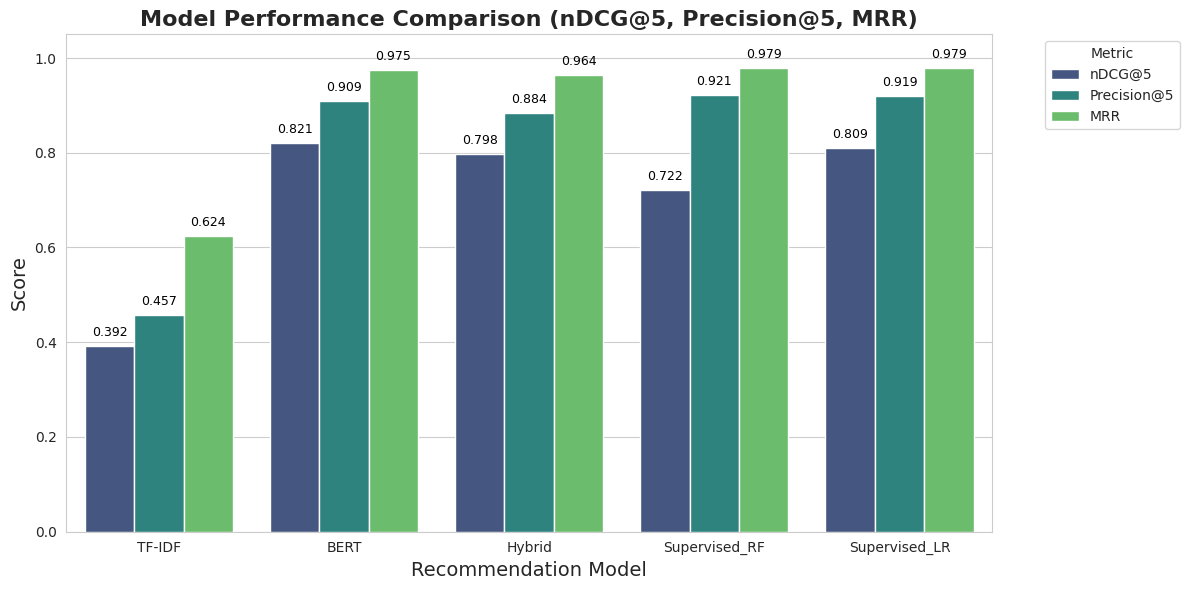

In [80]:

df_plot = df.reset_index().melt(
    id_vars='index', # 'index' holds the Model names after reset
    value_vars=['nDCG@5', 'Precision@5', 'MRR'], 
    var_name='Metric', 
    value_name='Score'
)
# Rename the index column to 'Model' for clarity in the plot
df_plot.rename(columns={'index': 'Model'}, inplace=True)

plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

# Define the order for the x-axis models
model_order = ['TF-IDF', 'BERT', 'Hybrid', 'Supervised_RF', 'Supervised_LR']

# Create the grouped bar plot
ax = sns.barplot(
    x='Model', 
    y='Score', 
    hue='Metric', 
    data=df_plot, 
    palette='viridis', 
    zorder=3,
    order=model_order 
)

# Add titles and labels
plt.title('Model Performance Comparison (nDCG@5, Precision@5, MRR)', fontsize=16, fontweight='bold')
plt.xlabel('Recommendation Model', fontsize=14)
plt.ylabel('Score', fontsize=14)
plt.ylim(0, 1.05) # Set y-limit from 0 to slightly above 1.0

# Add the score values on top of the bars for clarity
for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.annotate(
            f'{height:.3f}', 
            (p.get_x() + p.get_width() / 2., height),
            ha='center', va='bottom', fontsize=9, color='black', xytext=(0, 5),
            textcoords='offset points'
        )

# Adjust legend position and styling
plt.legend(title='Metric', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout() # Ensures everything fits
plt.show()